### Feature Filtering

In [ ]:
# Analysis
import os
import numpy as np
import pandas as pd
import pickle
import glob

# Plotting
import imageio
import PIL
from PIL import ImageDraw, Image
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif']=['Arial Unicode MS'] 
plt.rcParams['axes.unicode_minus']=False 

#### Bluring

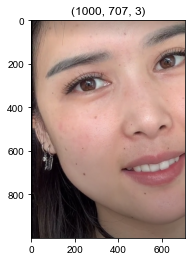

In [3]:
# 常应用于美肌，去掉脸上斑点
face = cv2.imread('images/freckle.png') 
face = cv2.cvtColor(face,4)
plt.imshow(face)
plt.title(face.shape);

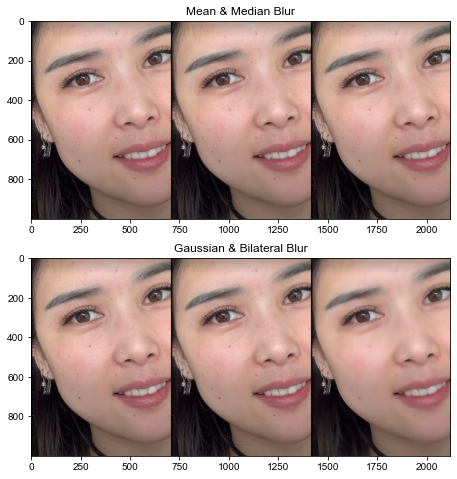

In [133]:
# 均值/中值滤波
plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
img_blur_mean = cv2.blur(face, (3,3)) # 均值滤波，(f,f)为奇数，增加f来增强模糊
img_blur_median = cv2.medianBlur(face, 3) # 中值滤波
plt.imshow(cv2.hconcat([face, img_blur_mean, img_blur_median]))
plt.title('Mean & Median Blur');

# 高斯滤波，增加f和std来增强模糊
plt.subplot(2,1,2)
img_blur_gaussian= cv2.GaussianBlur(face, (5,5), 0, 0) # std(x),std(y),若为0函数自动根据fxf计算，若不写std(y)默认和std(x)一样
img_blur_bilateral= cv2.bilateralFilter(face,20,65,65) # 高斯双边滤波, d, sigmaColor, sigmaSpace
plt.imshow(cv2.hconcat([face, img_blur_gaussian, img_blur_bilateral]))
plt.title('Gaussian & Bilateral Blur');

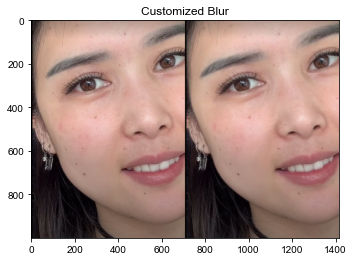

In [141]:
# 自定义均值滤波filter，对全脸模糊处理，为了模糊斑点，需要设置filter大小至少为斑点的2-3倍，才能通过周围浅色的肌肤和深色斑点取均值来淡化
plt.figure(figsize=(8,4))
kernel = np.ones((3,3))/(3*3) #通过增加f来扩大求均值的范围，增强模糊
face_blur=cv2.filter2D(face, -1, kernel) #ddepth=-1, 和原图相同维度
face_blur=cv2.filter2D(face_blur, -1, kernel) #也可以多次加filter来增强模糊
plt.imshow(cv2.hconcat([face, face_blur]))
plt.title('Customized Blur');

<Figure size 1440x576 with 0 Axes>

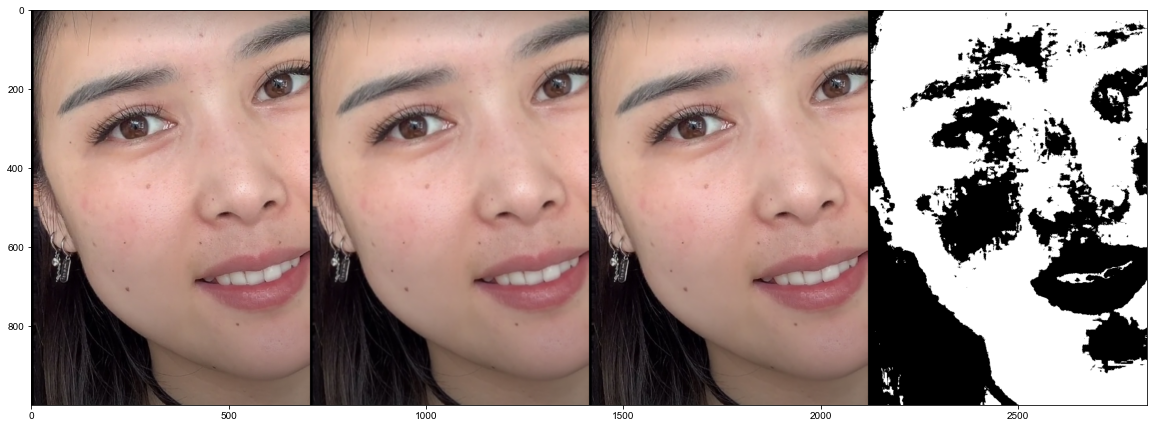

In [142]:
# 通过HSV格式的色调、饱和度和亮度进行肤色检测，只对肤色区域模糊处理
face_blur_hsv = cv2.cvtColor(face_blur, cv2.COLOR_RGB2HSV) #转格式
(_h, _s, _v) = cv2.split(face_blur_hsv) # 分别获取H、S、V的矩阵 (h,w)
(h,w) = _h.shape # 获取图片高宽

# 为了清晰看到是否成功检测到脸部，根据原图的大小创建一个全0的矩阵进行标记
skin = np.zeros(_h.shape, dtype=np.uint8)  

# 在全脸模糊的版本上，把不属于肤色的范围还原高清版本
skin_blur=face_blur.copy()

# 遍历全脸模糊图像
for i in  range(h):
    for j in  range(w):
        # 肤色范围：5<色调<70，18<饱和度<255，50<亮度<255
        if (_h[i][j]>5) and (_h[i][j]<70) and (_s[i][j]>18) and (_s[i][j]<255) and (_v[i][j]>50) and (_v[i][j]<255):
            skin[i][j] = 255 # 若像素值属于肤色范围，高亮标记为255，否则设为0
        else:
            skin[i][j] = 0
            skin_blur[i][j]=face[i][j] # 把不属于肤色范围的像素值还原为高清原图

# 但脸颊部分还不是识别很准确，可以进一步通过landmark detection和segmentation识别
skin = cv2.cvtColor(skin,4) #原始数组转为RGB
plt.figure(figsize=(20,8))
plt.imshow(cv2.hconcat([face,face_blur,skin_blur, skin]));

In [78]:
# 保存图片，可以保存拼接图，默认是以uint8 0-255格式来保存，因此0/1都会很黑
face_compare = cv2.cvtColor(cv2.hconcat([face,face_blur,skin_blur,skin]),4) #保存前需要明确再转为RGB
cv2.imwrite('face_compare.jpg',face_compare)

True

#### Edging

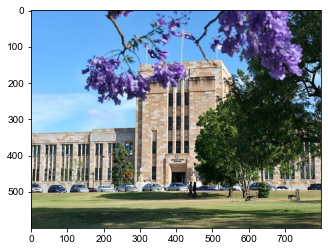

In [6]:
img = cv2.imread('images/uq.jpg') 
img = cv2.cvtColor(img, 4)
plt.imshow(img)

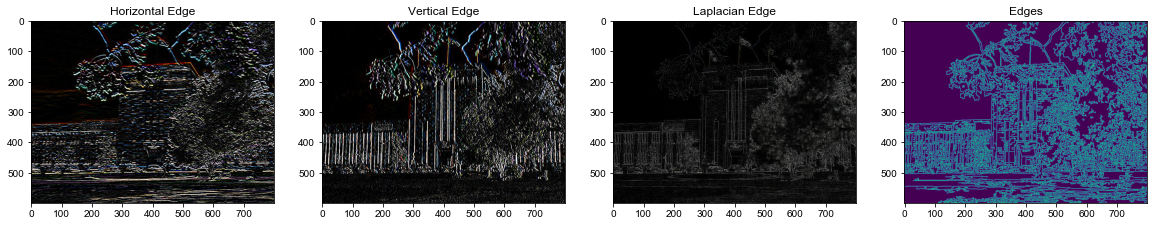

In [215]:
# 自定义滤波filter：边缘
plt.figure(figsize=(20,4))
plt.subplot(1,4,1)
kernel = np.array([[-1,-2,-1],[0,0,0],[1,2,1]]) #横线edge detector
img_h=cv2.filter2D(img, -1, kernel) #ddepth=-1, 和原图相同维度
plt.imshow(img_h)
plt.title('Horizontal Edge');

plt.subplot(1,4,2)
kernel = np.array([[-1,0,1],[-2,0,2],[-1,0,1]]) #竖线edge detector
img_h=cv2.filter2D(img, -1, kernel) 
plt.imshow(img_h)
plt.title('Vertical Edge');

plt.subplot(1,4,3)
kernel = np.array([[0,1,0],[1,-4,1],[0,1,0]]) #二阶梯度
img_l=cv2.filter2D(img, -1, kernel) 
plt.imshow(img_l)
plt.title('Laplacian Edge');

plt.subplot(1,4,4)
img_e= cv2.Canny(img, threshold1=30, threshold2=150) 
plt.imshow(img_e)
plt.title('Edges');

#### Sharpen

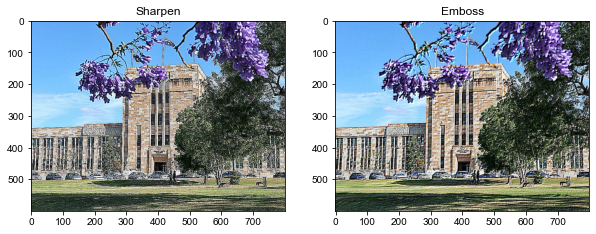

In [227]:
# 锐化
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
kernel = np.array([[-1,-1,-1],[-1,9,-1],[-1,-1,-1]]) 
# kernel = np.array([[0,-1,0],[-1,9,-1],[0,-1,0]])/4
img_sharp=cv2.filter2D(img, -1, kernel) 
plt.imshow(img_sharp)
plt.title('Sharpen');

plt.subplot(1,2,2)
kernel = np.array([[-2,-1,0],[-1,5,-1],[0,-1,2]]) 
img_h=cv2.filter2D(img, -1, kernel) 
plt.imshow(img_h)
plt.title('Emboss');